# Reinforcement Learning: CartPole Actor Critic Solution (Temporal Difference)

<img src="./screenshots/actor_critic.png" alt="drawing" width="1500"/>

In [2]:
import gym
import numpy as np
import random
import math

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Memory Buffer to store Experience Replay

In [3]:
class RingBuffer():
    def __init__(self, size):
        self.size = size
        self.buffer_ar = []
        for i in range(0, size):
            self.buffer_ar.append(0)
        self.counter = 0
        self.full = False
    
    def add(self, value):
        self.buffer_ar[self.counter] = value
        self.counter += 1
        if self.counter > self.size-1:
            self.counter = 0
            self.full = True
    
    def get_random(self, last_n, sample_size):
        if not self.full:
            last_n = self.counter
        if self.counter - last_n < 0:
            end = np.linspace(self.counter-last_n, -1, -1*(self.counter-last_n))
            start = np.linspace(0, self.counter-1, self.counter)
            window = np.concatenate((end, start))
        else:
            window = np.linspace(self.counter-last_n, self.counter-1, last_n)
            #print(window)
        random_index = np.random.choice(a=window, size=sample_size, replace=False)
        random_choices = []
        for i in random_index:
            random_choices.append(self.buffer_ar[int(i)])
        return random_choices
    
    def __repr__(self):
        return str(self.buffer_ar)

### Plot rewards and losses iteratively

In [4]:
def plot(frame, rewards, v_losses, theta_losses):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title("frame %s. reward: %s" % (frame, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('delta_v_loss')
    plt.plot(v_losses)
    plt.subplot(133)
    plt.title('theta_loss')
    plt.plot(theta_losses)
    plt.show()

### Build Actor & Critic Networks

In [5]:
class DVN(nn.Module):
    def __init__(self):
        super(DVN, self).__init__()
        self.fc1 = nn.Linear(4, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 1)
        
    def forward(self, states):
        out = F.relu(self.fc1(states))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

class PolicyGradient(nn.Module):
    def __init__(self):
        super(PolicyGradient, self).__init__()
        self.fc1 = nn.Linear(4, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 2)
        
    def forward(self, states):
        out = F.relu(self.fc1(states))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

#### Initialize Actor & Critic models

In [6]:
dvn = DVN()
policy_gradient = PolicyGradient()

#### Define Adam optimizer for both networks

In [7]:
dvn_optimizer = optim.Adam(dvn.parameters(), lr=0.01)
policy_gradient_optimizer = optim.Adam(policy_gradient.parameters(), lr=0.01)

### Training Loop

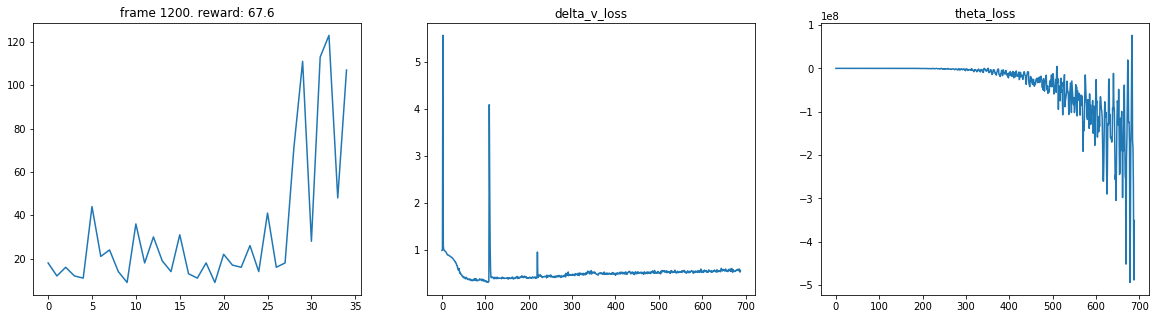

In [ ]:
memory_buffer = RingBuffer(2000)
GAMMA = 1.0
frame = 0
all_rewards = []
all_v_losses = []
all_theta_losses = []
env = gym.make('CartPole-v0')

for episode in range(2000):
    observation = env.reset()
    env.render()
    life_counter = 0
    
    while True:
        frame += 1
        life_counter += 1
        env.render()
        
        dvn_optimizer.zero_grad()
        policy_gradient_optimizer.zero_grad()
        
        #sample action from current policy
        observation_tensor = torch.tensor([observation], dtype=torch.float)
        output = policy_gradient(observation_tensor)
        softmax = nn.Softmax()
        output = softmax(output)
        output = output.view(output.size(1))
        output = output.detach().numpy()
        action = np.random.choice(a=[0, 1], size=1, p=output).item()
        
        #take action
        next_observation, reward, done, info = env.step(action)
            
        memory_buffer.add([observation, action, reward, next_observation, done])
        
        #start learning
        if frame >= 512:
            samples = memory_buffer.get_random(2000, 512)
            current_states = []
            actions = []
            rewards = []
            next_states = []
            is_done = []
            for sample in samples:
                current_states.append(sample[0])
                actions.append(sample[1])
                rewards.append(sample[2])
                next_states.append(sample[3])
                is_done.append(sample[4])
            
            current_states_tensor = torch.tensor(current_states, dtype=torch.float)
            v_current = dvn(current_states_tensor)
            v_current = v_current.view(v_current.size(0))
            
            next_states_tensor = torch.tensor(next_states, dtype=torch.float)
            v_next = dvn(next_states_tensor)
            v_next = v_next.view(v_next.size(0))
            
            rewards = torch.tensor(rewards, dtype=torch.float)
            is_done = torch.tensor(is_done, dtype=torch.float)
            
            delta_v = rewards + (GAMMA * (v_next * (1-is_done))) - v_current
            delta_v_copy = delta_v.clone()
            delta_v_copy = delta_v_copy.detach()
            
            action_probs = policy_gradient(current_states_tensor)
            action_probs = action_probs[range(0, action_probs.size(0)), actions]
            log_softmax = nn.LogSoftmax()
            log_action_probs = log_softmax(action_probs)
            
            theta = -1 * log_action_probs * delta_v_copy
            
            #backprop delta_v
            delta_v_loss = torch.mean(torch.pow(delta_v, 2))
            all_v_losses.append(delta_v_loss)
            delta_v_loss.backward()
            dvn_optimizer.step()
            
            #backprop theta
            theta_loss = torch.mean(theta)
            all_theta_losses.append(theta_loss)
            theta_loss.backward()
            policy_gradient_optimizer.step()
        
        #point to next state
        observation = next_observation.copy()
        
        if done:
            break
            
        if frame % 200 == 0:
            plot(frame, all_rewards, all_v_losses, all_theta_losses)
    
    all_rewards.append(life_counter)

In [ ]:
i